# Featurization

In [1]:
import os
# download and unzip keywords dataset
os.system('curl -O https://cdn.edgeimpulse.com/datasets/keywords2.zip')
os.system('unzip keywords2.zip')

256

In [2]:
!pip install speechpy
import speechpy
import numpy as np
from scipy.io import wavfile

train_test_split = 0.75  # fraction to have as training data

p = {'num_mfcc_cof': 13,
     'frame_length': 0.02,
     'frame_stride': 0.02,
     'filter_num': 32,
     'fft_length': 256,
     'window_size': 101,
     'low_frequency': 300,
     'preemph_cof': 0.98}

def get_features(fullfname):
    try:
        fs, data = wavfile.read(fullfname)
    except ValueError:
        print('failed to read file {}, continuing'.format(fullfname))
        return np.zeros(650)

    # generate features
    preemphasized = speechpy.processing.preemphasis(data, cof=p['preemph_cof'], shift=1)
    mfcc = speechpy.feature.mfcc(preemphasized, fs, frame_length=p['frame_length'],
                                  frame_stride=p['frame_stride'], num_cepstral=p['num_mfcc_cof'],
                                  num_filters=p['filter_num'], fft_length=p['fft_length'],
                                  low_frequency=p['low_frequency'])
    #print('mfcc shape', mfcc.shape)
    # TODO: Why is the output shape here (49, 13) and not (50, 13)?
    # For now just repeat last frame:
    mfcc2 = np.zeros((50, 13))
    mfcc2[:-1,:] = mfcc
    mfcc2[-1,:] = mfcc[-1,:]
    
    mfcc_cmvn = speechpy.processing.cmvnw(mfcc2, win_size=p['window_size'], variance_normalization=True)

    flattened = mfcc_cmvn.flatten()
    return flattened
  
def get_fnames(group):
    dir = group + '/'
    fnames = os.listdir(dir)
    fnames = [x for x in fnames if not x.startswith('.')]  # ignore .DS_Store
    fullnames = [dir + fname for fname in fnames]
    return fullnames
    
# collect a big list of filenames and a big list of labels
all_fnames = []
all_labels = []
for group in ['yes', 'unknown', 'noise']:
    fnames = get_fnames(group)
    label = 1 if group == 'yes' else 2
    repeat = 2 if group == 'yes' else 1  # oversample wake word class to balance dataset
    for _ in range(repeat):
        all_fnames.extend(fnames)
        for i in range(len(fnames)):
            all_labels.append(label)
    
# get a big list of mfcc features
n = len(all_fnames)
print('num samples: ', n)
all_features = np.zeros((0, 13*50))
for fname in all_fnames:
    features = get_features(fname)
    all_features = np.vstack((all_features, features))
all_labels = np.array(all_labels)

# shuffle the data randomly
idx = np.arange(n, dtype=int)
np.random.shuffle(idx)
features_shuffled = all_features[idx,:]
labels_shuffled = all_labels[idx]

# split the data into train and test sets
split = int(0.75 * n)
X = features_shuffled[:split,:]
Y = labels_shuffled[:split]
Xtest = features_shuffled[split:,:]
Ytest = labels_shuffled[split:]

num samples:  6036


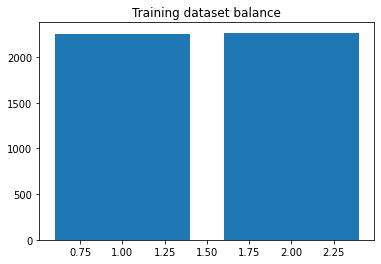

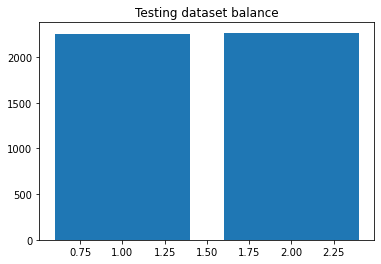

In [4]:
import matplotlib.pyplot as plt

# plot the dataset balance

def plot_dist(labels, title):
    plt.figure()
    nl = len(np.unique(labels))
    freqs = np.zeros(nl)
    for label in Y:
        freqs[label-1] += 1
    plt.bar(np.arange(nl)+1, freqs)
    plt.title(title)

plot_dist(Y, 'Training dataset balance')
plot_dist(Ytest, 'Testing dataset balance')

yes_features = X[Y==1,:]
unknown_features = X[Y!=1,:]

def plot_samples():
    # plot some samples
    for i in range(5):
        plt.figure()
        plt.subplot(121)
        plt.imshow(yes_features[i,:].reshape(50, 13).T)
        plt.title('Yes sample')
        plt.subplot(122)
        plt.imshow(unknown_features[i,:].reshape(50, 13).T)
        plt.title('Unknown sample')
  
def plot_average_sample():
    # plot the average yes and unknown sample
    avg_yes = np.zeros(50, 13)
    avg_unknown = np.zeros(50, 13)
    for i in range(len(yes_features)):
        avg_yes += yes_features[i,:].reshape(50, 13)
    for i in range(len(unknown_features)):
        avg_yes += unknown_features[i,:].reshape(50, 13)
    avg_yes / len(yes_features)
    avg_unknown / len(unknown_features)
    plt.figure()
    plt.imshow(avg_yes.T)
    plt.title('average yes')
    plt.figure()
    plt.imshow(avg_unknown.T)
    plt.title('average unknown')

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(13, 8, 3, padding=1, bias=False)
        self.pool = nn.MaxPool1d(2, 2, ceil_mode=True)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1, bias=False)
        self.fc1 = nn.Linear(16 * 13, 2, bias=False)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((x.shape[0], 50, 13)).transpose(1, 2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.reshape((x.shape[0], 16*13))
        x = self.fc1(x)
        return x

net = Net().to(device)

In [8]:
batch_size = 32
epochs = 500

Y_tensor = torch.Tensor(Y-1).type(torch.int64)
trainset = TensorDataset(torch.Tensor(X), Y_tensor)
trainloader = DataLoader(trainset, batch_size=batch_size)

Ytest_tensor = torch.Tensor(Ytest-1).type(torch.int64)
testset = TensorDataset(torch.Tensor(Xtest), Ytest_tensor)
testloader = DataLoader(testset, batch_size=batch_size)

def train(model: nn.Module, dataloader: DataLoader):
    model.train()  # turn on dropout layers

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        #for i in range(len(X)):
        #    inputs = torch.tensor(X[i,:]).reshape((1, 650))
        #    labels = torch.tensor(Y[i] - 1, dtype=torch.int64).reshape(1)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            #if i % 2000 == 1999:    # print every 2000 mini-batches
        if epoch % 10 == 9:
            print('[%d] loss: %.3f' % (epoch + 1, running_loss))

    print('Finished Training')

def test(model: nn.Module, dataloader: DataLoader, max_samples=None) -> float:
    model.eval()  # turn off dropout layers

    correct = 0
    total = 0
    n_inferences = 0

    with torch.no_grad():
        #for i in range(len(X)):
        #    inputs = torch.tensor(X[i,:]).reshape((1, 650))
        #    labels = torch.tensor(Y[i]).reshape(1)
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if max_samples:
                n_inferences += inputs.shape[0]
                if n_inferences > max_samples:
                    break
    
    return 100 * correct / total

In [9]:
train(net, trainloader)

[10] loss: 55.281
[20] loss: 33.340
[30] loss: 27.119
[40] loss: 23.348
[50] loss: 21.832
[60] loss: 21.010
[70] loss: 19.390
[80] loss: 18.650
[90] loss: 17.446
[100] loss: 16.648
[110] loss: 16.960
[120] loss: 15.435
[130] loss: 15.923
[140] loss: 16.592
[150] loss: 14.888
[160] loss: 14.890
[170] loss: 14.481
[180] loss: 13.230
[190] loss: 13.922
[200] loss: 13.670
[210] loss: 15.044
[220] loss: 13.878
[230] loss: 12.745
[240] loss: 13.326
[250] loss: 14.807
[260] loss: 12.513
[270] loss: 12.994
[280] loss: 13.098
[290] loss: 12.551
[300] loss: 12.822
[310] loss: 12.889
[320] loss: 11.980
[330] loss: 12.321
[340] loss: 12.723
[350] loss: 11.834
[360] loss: 12.211
[370] loss: 11.663
[380] loss: 12.456
[390] loss: 13.104
[400] loss: 11.821
[410] loss: 12.400
[420] loss: 11.814
[430] loss: 11.421
[440] loss: 11.552
[450] loss: 11.878
[460] loss: 11.108
[470] loss: 11.145
[480] loss: 10.749
[490] loss: 10.790
[500] loss: 11.277
Finished Training


In [10]:
score = test(net, trainloader)
print('Accuracy of the network on the train data: {}%'.format(score))
score = test(net, testloader)
print('Accuracy of the network on the test data: {}%'.format(score))

Accuracy of the network on the train data: 98.80715705765408%
Accuracy of the network on the test data: 97.6805831676607%


# Part 1: Visualize Weights

In [11]:
from copy import deepcopy

# A convenience function which we use to copy CNNs
def copy_model(model: nn.Module) -> nn.Module:
    result = deepcopy(model)

    # Copy over the extra metadata we've collected which copy.deepcopy doesn't capture
    if hasattr(model, 'input_activations'):
        result.input_activations = deepcopy(model.input_activations)

    for result_layer, original_layer in zip(result.children(), model.children()):
        if isinstance(result_layer, nn.Conv1d) or isinstance(result_layer, nn.Linear):
            if hasattr(original_layer.weight, 'scale'):
                result_layer.weight.scale = deepcopy(original_layer.weight.scale)
            if hasattr(original_layer, 'activations'):
                result_layer.activations = deepcopy(original_layer.activations)
            if hasattr(original_layer, 'output_scale'):
                result_layer.output_scale = deepcopy(original_layer.output_scale)

    return result

In [12]:
import matplotlib.pyplot as plt
import numpy as np

conv1 min -1.103, max 1.015, mean -0.003, 3-sigma (-0.723, 0.717), max-min 2.118, 3-sigma range 1.440
conv2 min -0.651, max 0.755, mean -0.084, 3-sigma (-0.744, 0.576), max-min 1.407, 3-sigma range 1.320
fc1 min -0.433, max 0.396, mean 0.003, 3-sigma (-0.553, 0.558), max-min 0.828, 3-sigma range 1.112


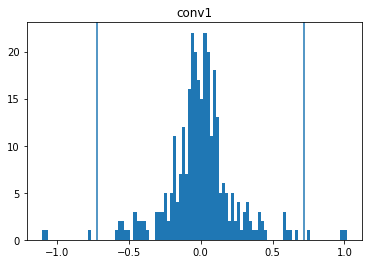

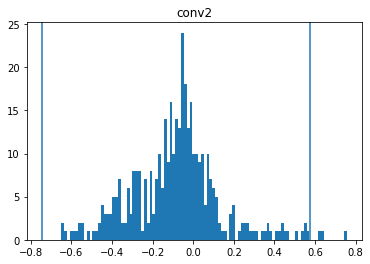

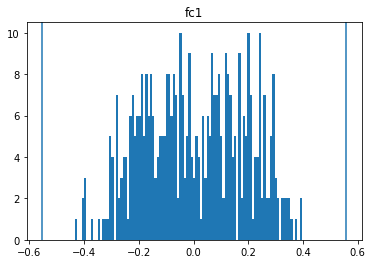

In [13]:
# ADD YOUR CODE HERE to plot distributions of weights

# You can get a flattened vector of the weights of fc1 like this:
#   fc1_weights = net.fc1.weight.data.cpu().view(-1)
# Try plotting a histogram of fc1_weights (and the weights of all the other layers as well)

def show_weight_dist(layer, title):
  weights = layer.weight.data.cpu().view(-1)
  plt.figure()
  plt.hist(weights, 100)
  plt.title(title)
  min = weights.min()
  max = weights.max()
  mean = weights.mean()
  std = weights.std()
  plt.axvline(mean - 3*std)
  plt.axvline(mean + 3*std)
  print('{} min {:.03f}, max {:.03f}, mean'.format(title, min, max) +
         ' {:.03f}, 3-sigma ({:.03f}, {:.03f})'.format(mean, mean - 3*std, mean + 3*std) +
         ', max-min {:.03f}, 3-sigma range {:.03f}'.format(max - min, 6*std))

show_weight_dist(net.conv1, 'conv1')
show_weight_dist(net.conv2, 'conv2')
show_weight_dist(net.fc1, 'fc1')

# fc3 has a 3-sigma range that is greater than the max-min, would want to use
# max-min as the range and not the 3-sigma one

# Part 2: Quantize Weights

In [14]:
net_q2 = copy_model(net)

In [15]:
from typing import Tuple

def quantized_weights(weights: torch.Tensor) -> Tuple[torch.Tensor, float]:
    '''
    Quantize the weights so that all values are integers between -128 and 127.
    You may want to use the total range, 3-sigma range, or some other range when
    deciding just what factors to scale the float32 values by.

    Parameters:
    weights (Tensor): The unquantized weights

    Returns:
    (Tensor, float): A tuple with the following elements:
                        * The weights in quantized form, where every value is an integer between -128 and 127.
                          The "dtype" will still be "float", but the values themselves should all be integers.
                        * The scaling factor that your weights were multiplied by.
                          This value does not need to be an 8-bit integer.
    '''

    # ADD YOUR CODE HERE
    # std = weights.std()
    absmax = weights.abs().max()
    # scale = 127 / (3 * std)  # 3-sigma
    scale = 127 / absmax
    result = (weights * scale).round()
    #return torch.clamp(result, min=-128, max=127), scale
    return result, scale

In [16]:
def quantize_layer_weights(model: nn.Module):
    for layer in model.children():
        if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear):
            q_layer_data, scale = quantized_weights(layer.weight.cpu().data)
            q_layer_data = q_layer_data.to(device)

            layer.weight.data = q_layer_data
            layer.weight.scale = scale

            if (q_layer_data < -128).any() or (q_layer_data > 127).any():
                raise Exception("Quantized weights of {} layer include values out of bounds for an 8-bit signed integer".format(layer.__class__.__name__))
            if (q_layer_data != q_layer_data.round()).any():
                raise Exception("Quantized weights of {} layer include non-integer values".format(layer.__class__.__name__))

quantize_layer_weights(net_q2)

In [17]:
score = test(net_q2, trainloader)
print('Accuracy of the network after quantizing all weights (train): {}%'.format(score))
score = test(net_q2, testloader)
print('Accuracy of the network after quantizing all weights (test): {}%'.format(score))

Accuracy of the network after quantizing all weights (train): 98.78506737353656%
Accuracy of the network after quantizing all weights (test): 97.6805831676607%


In [18]:
net_q2.conv1.weight.data.cpu().numpy().min()

-127.0

# Part 3: Visualize Activations

In [19]:
def register_activation_profiling_hooks(model: Net):
    model.input_activations = np.empty(0)
    model.conv1.activations = np.empty(0)
    model.conv2.activations = np.empty(0)
    model.fc1.activations = np.empty(0)

    model.profile_activations = True

    def conv1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.input_activations = np.append(model.input_activations, x[0].cpu().flatten())
    model.conv1.register_forward_hook(conv1_activations_hook)

    def conv2_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv1.activations = np.append(model.conv1.activations, x[0].cpu().flatten())
    model.conv2.register_forward_hook(conv2_activations_hook)

    def fc1_activations_hook(layer, x, y):
        if model.profile_activations:
            model.conv2.activations = np.append(model.conv2.activations, x[0].cpu().flatten())
            model.fc1.activations = np.append(model.fc1.activations, y[0].cpu().flatten())
    model.fc1.register_forward_hook(fc1_activations_hook)

In [20]:
net_q3 = copy_model(net)
register_activation_profiling_hooks(net_q3)

# Run through the training dataset again while profiling the input and output activations this time
# We don't actually have to perform gradient descent for this, so we can use the "test" function
test(net_q3, trainloader, max_samples=400)
net_q3.profile_activations = False

In [21]:
input_activations = net_q3.input_activations
conv1_output_activations = net_q3.conv1.activations
conv2_output_activations = net_q3.conv2.activations
fc1_output_activations = net_q3.fc1.activations

input min -4.885, max 6.131, mean 0.000, 3-sigma (-3.001, 3.001), max-min 11.016, 3-sigma range 6.002
conv1 min 0.000, max 9.238, mean 0.819, 3-sigma (-2.272, 3.911), max-min 9.238, 3-sigma range 6.183
conv2 min 0.000, max 3.595, mean 0.164, 3-sigma (-0.982, 1.310), max-min 3.595, 3-sigma range 2.292
fc1 min -5.922, max 5.655, mean 0.032, 3-sigma (-9.108, 9.172), max-min 11.576, 3-sigma range 18.280


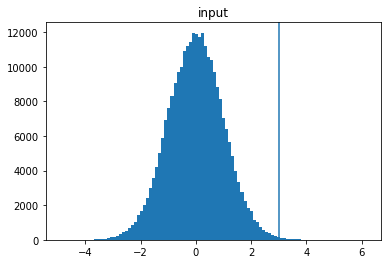

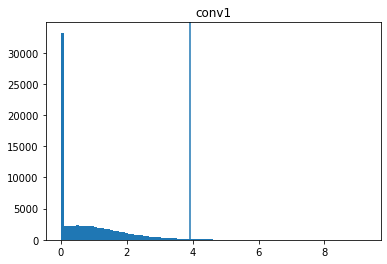

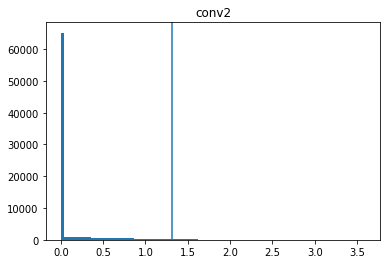

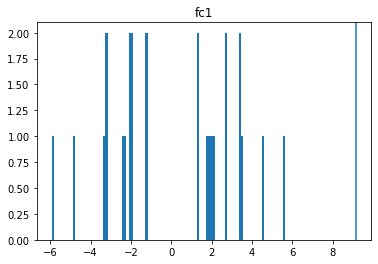

In [22]:
# ADD YOUR CODE HERE to plot distributions of activations

def show_weight_dist(data, title):
    plt.figure()
    plt.hist(data, 100)
    plt.title(title)
    min = data.min()
    max = data.max()
    mean = data.mean()
    std = data.std()
    #plt.axvline(mean - 3*std)
    plt.axvline(mean + 3*std)
    print('{} min {:.03f}, max {:.03f}, mean'.format(title, min, max) +
          ' {:.03f}, 3-sigma ({:.03f}, {:.03f})'.format(mean, mean - 3*std, mean + 3*std) +
          ', max-min {:.03f}, 3-sigma range {:.03f}'.format(max - min, 6*std))

show_weight_dist(input_activations, 'input')
show_weight_dist(conv1_output_activations, 'conv1')
show_weight_dist(conv2_output_activations, 'conv2')
show_weight_dist(fc1_output_activations, 'fc1')

# Plot histograms of the following variables, and calculate their ranges and 3-sigma ranges:
#   input_activations
#   conv1_output_activations
#   conv2_output_activations
#   fc1_output_activations


# Part 4: Quantize Activations

In [23]:
from typing import List

class NetQuantized(nn.Module):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantized, self).__init__()
        
        net_init = copy_model(net_with_weights_quantized)

        self.conv1 = net_init.conv1
        self.pool = net_init.pool
        self.conv2 = net_init.conv2
        self.fc1 = net_init.fc1

        for layer in self.conv1, self.conv2, self.fc1:
            def pre_hook(l, x):
                x = x[0]
                if (x < -128).any() or (x > 127).any():
                    raise Exception("Input to {} layer is out of bounds for an 8-bit signed integer".format(l.__class__.__name__))
                if (x != x.round()).any():
                    raise Exception("Input to {} layer has non-integer values".format(l.__class__.__name__))

            layer.register_forward_pre_hook(pre_hook)

        # Calculate the scaling factor for the initial input to the CNN
        self.input_activations = net_with_weights_quantized.input_activations
        self.input_scale = NetQuantized.quantize_initial_input(self.input_activations)

        # Calculate the output scaling factors for all the layers of the CNN
        preceding_layer_scales = []
        for layer in self.conv1, self.conv2, self.fc1:
            layer.output_scale = NetQuantized.quantize_activations(layer.activations, layer.weight.scale, self.input_scale, preceding_layer_scales)
            preceding_layer_scales.append((layer.weight.scale, layer.output_scale))

    @staticmethod
    def quantize_initial_input(pixels: np.ndarray) -> float:
        '''
        Calculate a scaling factor for the images that are input to the first layer of the CNN.

        Parameters:
        pixels (ndarray): The values of all the pixels which were part of the input image during training

        Returns:
        float: A scaling factor that the input should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        absmax = np.abs(pixels).max()
        return 127 / absmax

    @staticmethod
    def quantize_activations(activations: np.ndarray, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> float:
        '''
        Calculate a scaling factor to multiply the output of a layer by.

        Parameters:
        activations (ndarray): The values of all the pixels which have been output by this layer during training
        n_w (float): The scale by which the weights of this layer were multiplied as part of the "quantize_weights" function you wrote earlier
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        float: A scaling factor that the layer output should be multiplied by before being fed into the first layer.
               This value does not need to be an 8-bit integer.
        '''

        # ADD YOUR CODE HERE
        max = activations.max()
        product = 1
        for prev_scaling in ns:
            product *= prev_scaling[0] * prev_scaling[1]
        scale = 127 / (n_w * product * n_initial_input * max)  # return this for original output
        return 2 ** np.floor(np.log2(scale))  # make scaling a power of 2!

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # You can access the output activation scales like this:
        #   fc1_output_scale = self.fc1.output_scale

        # To make sure that the outputs of each layer are integers between -128 and 127, you may need to use the following functions:
        #   * torch.Tensor.round
        #   * torch.clamp

        # ADD YOUR CODE HERE
        x = x.reshape((x.shape[0], 50, 13)).transpose(1, 2)
        x = torch.clamp(torch.round(x * self.input_scale), min=-128, max=127)
        x = self.pool(torch.clamp(torch.floor(F.relu(self.conv1(x)) * self.conv1.output_scale), min=-128, max=127))
        x = self.pool(torch.clamp(torch.floor(F.relu(self.conv2(x)) * self.conv2.output_scale), min=-128, max=127))
        x = x.reshape((x.shape[0], 16*13))
        #x = torch.clamp(torch.floor(self.fc1(x) * self.fc1.output_scale), min=-128, max=127)
        x = self.fc1(x)
        return x

In [24]:
# Merge the information from net_q2 and net_q3 together
net_init = copy_model(net_q2)
net_init.input_activations = deepcopy(net_q3.input_activations)
for layer_init, layer_q3 in zip(net_init.children(), net_q3.children()):
    if isinstance(layer_init, nn.Conv1d) or isinstance(layer_init, nn.Linear):
        layer_init.activations = deepcopy(layer_q3.activations)

net_quantized = NetQuantized(net_init)

for l in [net_quantized.conv1, net_quantized.conv2, net_quantized.fc1]:
    print(np.log2(l.output_scale))

tensor(-8.)
tensor(-6.)
tensor(-9.)


In [25]:
score = test(net_quantized, trainloader)
print('Accuracy of the network after quantizing activations (train): {}%'.format(score))
score = test(net_quantized, testloader)
print('Accuracy of the network after quantizing activations (test): {}%'.format(score))

Accuracy of the network after quantizing activations (train): 98.85133642588912%
Accuracy of the network after quantizing activations (test): 97.74685222001325%


# Part 5: Quantize Biases

In [26]:
class NetWithBias(nn.Module):
    def __init__(self):
        super(NetWithBias, self).__init__()
        self.conv1 = nn.Conv1d(13, 8, 3, padding=1, bias=True)
        self.pool = nn.MaxPool1d(2, 2, ceil_mode=True)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv1d(8, 16, 3, padding=1, bias=True)
        self.fc1 = nn.Linear(16 * 13, 2, bias=True)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.reshape((x.shape[0], 50, 13)).transpose(1, 2)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.reshape((x.shape[0], 16*13))
        x = self.fc1(x)
        return x

net_with_bias = NetWithBias().to(device)

In [27]:
train(net_with_bias, trainloader)

[10] loss: 62.138
[20] loss: 38.561
[30] loss: 28.431
[40] loss: 23.876
[50] loss: 20.896
[60] loss: 20.488
[70] loss: 18.399
[80] loss: 18.213
[90] loss: 17.099
[100] loss: 16.536
[110] loss: 15.703
[120] loss: 16.340
[130] loss: 15.088
[140] loss: 14.985
[150] loss: 14.614
[160] loss: 14.366
[170] loss: 14.264
[180] loss: 13.663
[190] loss: 13.873
[200] loss: 13.866
[210] loss: 13.141
[220] loss: 12.758
[230] loss: 13.170
[240] loss: 11.777
[250] loss: 11.640
[260] loss: 12.395
[270] loss: 12.166
[280] loss: 11.114
[290] loss: 12.458
[300] loss: 11.189
[310] loss: 11.802
[320] loss: 12.069
[330] loss: 10.944
[340] loss: 12.660
[350] loss: 11.461
[360] loss: 11.260
[370] loss: 10.928
[380] loss: 11.372
[390] loss: 10.166
[400] loss: 11.722
[410] loss: 9.755
[420] loss: 11.386
[430] loss: 10.649
[440] loss: 10.041
[450] loss: 11.278
[460] loss: 10.449
[470] loss: 10.801
[480] loss: 10.840
[490] loss: 9.968
[500] loss: 9.418
Finished Training


In [28]:
score = test(net_with_bias, trainloader)
print('Accuracy of the network with bias (train): {}%'.format(score))
score = test(net_with_bias, testloader)
print('Accuracy of the network with bias (test): {}%'.format(score))

Accuracy of the network with bias (train): 99.13850231941683%
Accuracy of the network with bias (test): 98.07819748177602%


In [29]:
register_activation_profiling_hooks(net_with_bias)
test(net_with_bias, trainloader, max_samples=400)
net_with_bias.profile_activations = False

In [30]:
net_with_bias_with_quantized_weights = copy_model(net_with_bias)
quantize_layer_weights(net_with_bias_with_quantized_weights)

score = test(net_with_bias_with_quantized_weights, trainloader)
print('Accuracy of the network on the train images after all the weights are quantized but the bias isn\'t: {}%'.format(score))
score = test(net_with_bias_with_quantized_weights, testloader)
print('Accuracy of the network on the test images after all the weights are quantized but the bias isn\'t: {}%'.format(score))

Accuracy of the network on the train images after all the weights are quantized but the bias isn't: 58.47139385906782%
Accuracy of the network on the test images after all the weights are quantized but the bias isn't: 58.316766070245194%


In [31]:
class NetQuantizedWithBias(NetQuantized):
    def __init__(self, net_with_weights_quantized: nn.Module):
        super(NetQuantizedWithBias, self).__init__(net_with_weights_quantized)


        for i, l in enumerate([self.conv1, self.conv2, self.fc1]):
            preceding_scales = [(layer.weight.scale, layer.output_scale) for layer in self.children() if isinstance(layer, nn.Conv1d) or isinstance(layer, nn.Linear)][:i]

            l.bias.data = NetQuantizedWithBias.quantized_bias(
                l.bias.data,
                l.weight.scale,
                self.input_scale,
                preceding_scales
            )

            if (l.bias.data < -2147483648).any() or (l.bias.data > 2147483647).any():
                raise Exception("Bias has values which are out of bounds for an 32-bit signed integer")
            if (l.bias.data != l.bias.data.round()).any():
                raise Exception("Bias has non-integer values")

    @staticmethod
    def quantized_bias(bias: torch.Tensor, n_w: float, n_initial_input: float, ns: List[Tuple[float, float]]) -> torch.Tensor:
        '''
        Quantize the bias so that all values are integers between -2147483648 and 2147483647.

        Parameters:
        bias (Tensor): The floating point values of the bias
        n_w (float): The scale by which the weights of this layer were multiplied
        n_initial_input (float): The scale by which the initial input to the neural network was multiplied
        ns ([(float, float)]): A list of tuples, where each tuple represents the "weight scale" and "output scale" (in that order) for every preceding layer

        Returns:
        Tensor: The bias in quantized form, where every value is an integer between -2147483648 and 2147483647.
                The "dtype" will still be "float", but the values themselves should all be integers.
        '''

        # ADD YOUR CODE HERE
        product = 1
        for prev_scaling in ns:
            product *= prev_scaling[0] * prev_scaling[1]
        scale = (n_w * product * n_initial_input)
        return (bias * scale).round()
        #return torch.clamp((bias * 2.5).round(), min=-2147483648, max=2147483647)

In [32]:
net_quantized_with_bias = NetQuantizedWithBias(net_with_bias_with_quantized_weights)

In [33]:
score = test(net_quantized_with_bias, trainloader)
print('Accuracy of the network with quantized weights and bias (train): {}%'.format(score))
score = test(net_quantized_with_bias, testloader)
print('Accuracy of the network with quantized weights and bias (test): {}%'.format(score))

Accuracy of the network with quantized weights and bias (train): 99.20477137176938%
Accuracy of the network with quantized weights and bias (test): 98.01192842942346%


In [34]:
print('Number of parameters in each layer:')
for p in net_quantized_with_bias.parameters():
    print(p.numel())

Number of parameters in each layer:
312
8
384
16
416
2


# Part 6: Numpy model

In [35]:
conv1_weights = net_quantized_with_bias.conv1.weight.data.cpu().numpy().astype(np.int8)
conv1_biases = net_quantized_with_bias.conv1.bias.data.cpu().numpy().astype(np.int32)
conv2_weights = net_quantized_with_bias.conv2.weight.data.cpu().numpy().astype(np.int8)
conv2_biases = net_quantized_with_bias.conv2.bias.data.cpu().numpy().astype(np.int32)
fc1_weights = net_quantized_with_bias.fc1.weight.data.cpu().numpy().astype(np.int8)
fc1_biases = net_quantized_with_bias.fc1.bias.data.cpu().numpy().astype(np.int32)

# transpose the weights so that they match the numpy model
conv1_weights = np.transpose(conv1_weights, (2, 1, 0))
conv2_weights = np.transpose(conv2_weights, (2, 1, 0))
#fc1_weights = np.transpose(fc1_weights, (1, 0))  # works if x is transposed
fc1_weights = np.transpose(fc1_weights.reshape(2, 16, 13), (0, 2, 1)).reshape(2, 208).T

# get the featuremap scalings
input_scale = net_quantized_with_bias.input_scale
conv1_output_scale = net_quantized_with_bias.conv1.output_scale
conv2_output_scale = net_quantized_with_bias.conv2.output_scale
fc1_output_scale = net_quantized_with_bias.fc1.output_scale

# bitshifts is the amount that each featuremap is shifted to the right eg: 8 would be a divide by 256
bitshifts = -np.log2(np.array([conv1_output_scale, conv2_output_scale, fc1_output_scale])).astype(np.int8)

input_scale_arr = np.array(input_scale)  # single element array for input featuremap scaling

weights_list = [input_scale_arr, bitshifts,
                conv1_weights, conv1_biases,
                conv2_weights, conv2_biases,
                fc1_weights, fc1_biases]
np.savez('parameters_quantized.npz', *weights_list)

In [36]:
weights_archive = np.load('parameters_quantized.npz')
weights_list = [weights_archive['arr_{}'.format(i)] for i in range(len(weights_archive))]

for weights in weights_list:
    print(weights.shape)

input_scale = weights_list[0]
bitshifts = weights_list[1]
conv1_weights = weights_list[2]
conv1_biases = weights_list[3]
conv2_weights = weights_list[4]
conv2_biases = weights_list[5]
fc1_weights = weights_list[6]
fc1_biases = weights_list[7]

()
(3,)
(3, 13, 8)
(8,)
(3, 8, 16)
(16,)
(208, 2)
(2,)


In [39]:
def relu(x):
    return np.maximum(x, 0)

def conv1d_single_kernel(x, weights, bias):
    '''Perform convolution of a input feature map with a single filter and bias.
    
    featuremap dims are (time, n_coeffs), so (50, 13)
    '''
    out = np.zeros(x.shape[0], dtype=np.int64)  # output length is the same
    x_pad = np.zeros((x.shape[0]+2, x.shape[1]), dtype=np.int64)
    x_pad[1:-1,:] = x  # zero padding
    for i in range(x.shape[0]):
        section = x_pad[i:i+3,:]
        out[i] = relu(np.sum(section * weights) + bias)
    return out

def conv1d_multi_kernel(x, weights, biases):
    n_kernels = weights.shape[2]
    out = np.zeros((x.shape[0], n_kernels), dtype=np.int64)
    for i in range(n_kernels):
        kernel = weights[:,:,i]
        out[:,i] = conv1d_single_kernel(x, kernel, biases[i])
    return out

def max_pool_1d(x):
    out = np.zeros((int(np.ceil(x.shape[0] / 2)), x.shape[1]), dtype=np.int8)
    for j in range(x.shape[1]):
        for i in range(int(np.floor(x.shape[0] / 2))):
            out[i, j] = np.maximum(x[2*i, j], x[2*i+1, j])
        if (x.shape[0] % 2 == 1):
            out[-1, j] = x[-1, j]
    return out

def fc(x, weights, biases):
    x = x.flatten()
    out = np.matmul(x, weights, dtype=np.int64) + biases
    return out

def scale_feature_map(x, shift):
    '''Scale a featuremap to a byte range given the amount to right shift by.

    Since all weight, bias, and activation quantizations are mapped using the full range
    of values, there is not any need for clamping the values to the range [-128, 127].
    However, it is still useful since the quantization could be changed to not map to the
    full range of the unquantized values.
    '''
    x = np.right_shift(x, shift)
    x = np.clip(x, -128, 127)
    x = x.astype(np.int8)
    return x

def get_numpy_pred(features):
    out = np.zeros((features.shape[0], 2), dtype=np.int64)
    for i in range(features.shape[0]):
        # condition input feature map
        x = features[i]
        x = x.reshape((int(x.size / 13), 13))
        x = np.clip(np.round(x * input_scale), -128, 127).astype(np.int8)

        # conv1
        x = conv1d_multi_kernel(x, conv1_weights, conv1_biases)
        x = scale_feature_map(x, bitshifts[0])
        x = max_pool_1d(x)

        # conv2
        x = conv1d_multi_kernel(x, conv2_weights, conv2_biases)
        x = scale_feature_map(x, bitshifts[1])
        x = max_pool_1d(x)

        # fc1
        x = fc(x, fc1_weights, fc1_biases)
        
        out[i] = x
    return out

In [40]:
numpy_pred = get_numpy_pred(X[:1,:])
numpy_pred.shape

(1, 2)

In [45]:
def get_torch_pred(input):
    return net_quantized_with_bias.forward(torch.tensor(input, device=device, dtype=torch.float)).detach().cpu().numpy()

torch_pred = get_torch_pred(X[:1,:])
torch_pred.shape

(1, 2)

In [46]:
numpy_pred - torch_pred

array([[0., 0.]])

In [47]:
# compare output for each sample in test data

n_err = 0
for i in range(Xtest.shape[0]):
    numpy_pred = get_numpy_pred(X[i:i+1, :])
    torch_pred = get_torch_pred(X[i:i+1, :])
    diff = numpy_pred - torch_pred
    if np.abs(diff).max() > 1e-9:
        n_err += 1
        print('Difference between outputs at sample ', i)
    if n_err > 10:
        break

if n_err == 0:
    print('No differences between numpy model and torch model!')

No differences between numpy model and torch model!
